In [263]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.signal import hilbert, savgol_filter, find_peaks
from scipy.interpolate import interp1d
from BesselML import Promising_solution, Solution, Problem, create_arbitrary_constraint
import sympy as sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


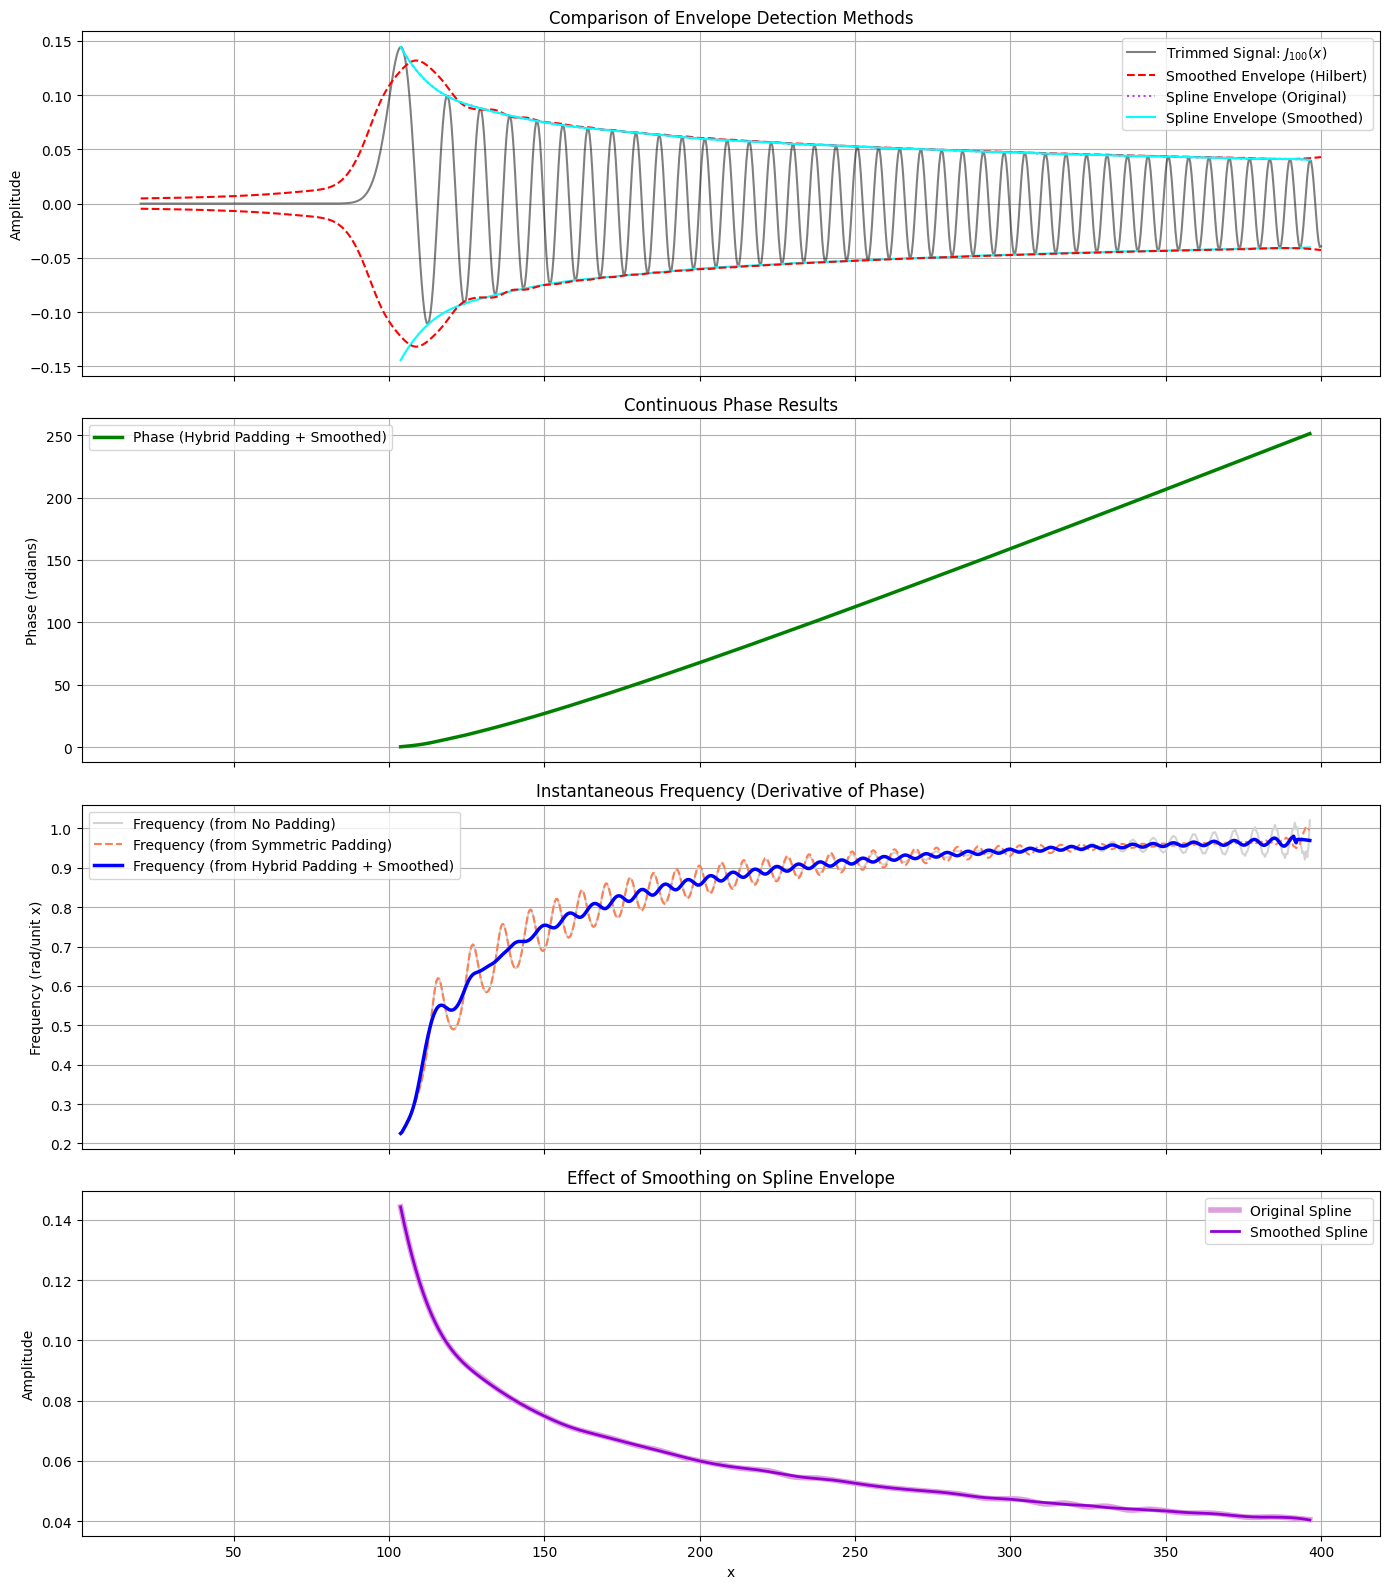

In [487]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.signal import hilbert, savgol_filter, find_peaks
from scipy.interpolate import interp1d

# --- Step 1: Generate Original Signal ---
order = 100
x_data_hilbert = np.linspace(0, 400, 1000) 
y_true_bessel = special.jv(order, x_data_hilbert)
dt = x_data_hilbert[1] - x_data_hilbert[0]

# --- Step 2: Robust Hilbert Transform using HYBRID Padding ---
pad_width = int(len(y_true_bessel) * 0.10)
fit_points = 50 
y_padded_for_start = np.pad(y_true_bessel, (pad_width, 0), mode='symmetric')
y_start_pad = y_padded_for_start[:pad_width]
end_coeffs = np.polyfit(x_data_hilbert[-fit_points:], y_true_bessel[-fit_points:], 1)
end_poly = np.poly1d(end_coeffs)
x_end_pad = np.arange(1, pad_width + 1) * dt + x_data_hilbert[-1]
y_end_pad = end_poly(x_end_pad)
y_padded = np.concatenate([y_start_pad, y_true_bessel, y_end_pad])
analytic_signal_padded = hilbert(y_padded)
analytic_signal = analytic_signal_padded[pad_width:-pad_width]

# --- For comparison purposes only ---
analytic_signal_simple = hilbert(y_true_bessel)
y_padded_symm_full = np.pad(y_true_bessel, pad_width, mode='symmetric')
analytic_signal_symm_full = hilbert(y_padded_symm_full)
analytic_signal_symm = analytic_signal_symm_full[pad_width:-pad_width]

# --- Step 3: Extract and Polish Phase ---
target_amplitude = np.abs(analytic_signal)
target_phase = np.unwrap(np.angle(analytic_signal))
phase_window = 41 
phase_polyorder = 3
target_phase = savgol_filter(target_phase, phase_window, phase_polyorder)

# Get phases for comparison plot
target_phase_simple = np.unwrap(np.angle(analytic_signal_simple))
target_phase_symm = np.unwrap(np.angle(analytic_signal_symm))

# --- Step 4: Trim the Edges ---
trim_percent = 5.0
trim_points = int(len(x_data_hilbert) * trim_percent / 100)
x_data_trimmed = x_data_hilbert[trim_points:]
y_true_bessel_trimmed = y_true_bessel[trim_points:]
target_amplitude_trimmed = target_amplitude[trim_points:] 
target_phase_trimmed = target_phase[trim_points:]
target_phase_simple_trimmed = target_phase_simple[trim_points:]
target_phase_symm_trimmed = target_phase_symm[trim_points:]

# --- Step 5: Envelope Processing and Final Slicing ---
window_length = 101 
polyorder = 3
smooth_amplitude_trimmed = savgol_filter(target_amplitude_trimmed, window_length, polyorder) 
peaks_indices, _ = find_peaks(y_true_bessel_trimmed, distance=10) 
x_peaks = x_data_trimmed[peaks_indices]
y_peaks = y_true_bessel_trimmed[peaks_indices]
envelope_function = interp1d(x_peaks, y_peaks, kind='cubic', bounds_error=False, fill_value=0)
spline_amplitude_trimmed = envelope_function(x_data_trimmed)
spline_amplitude_trimmed[spline_amplitude_trimmed < 0] = 0
first_peak_index = peaks_indices[0]
last_peak_index = peaks_indices[-1]
x_data_spline_final = x_data_trimmed[first_peak_index : last_peak_index + 1]
spline_amplitude_final = spline_amplitude_trimmed[first_peak_index : last_peak_index + 1]

# Slice all phase versions for the final plot
target_phase_spline_final = target_phase_trimmed[first_peak_index : last_peak_index + 1] 
target_phase_simple_spline_final = target_phase_simple_trimmed[first_peak_index : last_peak_index + 1]
target_phase_symm_spline_final = target_phase_symm_trimmed[first_peak_index : last_peak_index + 1]

# --- NEW: Step 5D: Smooth the final spline envelope ---
# A smaller window is often better for an already smooth spline
spline_window = 71
spline_polyorder = 3
spline_amplitude_smoothed = savgol_filter(spline_amplitude_final, spline_window, spline_polyorder)
# --- END NEW ---

# --- Step 5E: Calculate Instantaneous Frequency (Derivative of Phase) ---
inst_freq_simple = np.gradient(target_phase_simple_spline_final, x_data_spline_final)
inst_freq_symm = np.gradient(target_phase_symm_spline_final, x_data_spline_final)
inst_freq_final = np.gradient(target_phase_spline_final, x_data_spline_final)

# --- Step 6: Visualize All Results ---
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# Plot 1: Amplitude Envelopes
ax1.plot(x_data_trimmed, y_true_bessel_trimmed, label=f'Trimmed Signal: $J_{{{order}}}(x)$', color='k', alpha=0.5)
ax1.plot(x_data_trimmed, smooth_amplitude_trimmed, label='Smoothed Envelope (Hilbert)', color='red', linestyle='--')
ax1.plot(x_data_spline_final, spline_amplitude_final, label='Spline Envelope (Original)', color='darkviolet', linestyle=':', alpha=0.7)
# MODIFIED: Plot the new smoothed spline
ax1.plot(x_data_spline_final, spline_amplitude_smoothed, label='Spline Envelope (Smoothed)', color='cyan', linestyle='-')
ax1.plot(x_data_spline_final, -spline_amplitude_smoothed, color='cyan', linestyle='-')
ax1.plot(x_data_trimmed, -smooth_amplitude_trimmed, color='red', linestyle='--')
ax1.set_title('Comparison of Envelope Detection Methods')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True)

# Plot 2: Unwrapped Phase
#ax2.plot(x_data_spline_final, target_phase_simple_spline_final, label='Phase (No Padding)', color='lightgray')
#ax2.plot(x_data_spline_final, target_phase_symm_spline_final, label='Phase (Symmetric Padding)', color='coral', linestyle='--')
ax2.plot(x_data_spline_final, target_phase_spline_final, label='Phase (Hybrid Padding + Smoothed)', color='green', linewidth=2.5)
ax2.set_title('Continuous Phase Results')
ax2.set_ylabel('Phase (radians)')
ax2.legend()
ax2.grid(True)

# Plot 3: Instantaneous Frequency
ax3.plot(x_data_spline_final, inst_freq_simple, label='Frequency (from No Padding)', color='lightgray')
ax3.plot(x_data_spline_final, inst_freq_symm, label='Frequency (from Symmetric Padding)', color='coral', linestyle='--')
ax3.plot(x_data_spline_final, inst_freq_final, label='Frequency (from Hybrid Padding + Smoothed)', color='blue', linewidth=2.5)
ax3.set_title('Instantaneous Frequency (Derivative of Phase)')
ax3.set_ylabel('Frequency (rad/unit x)')
ax3.legend()
ax3.grid(True)

# MODIFIED: Plot 4: Original Spline vs. Smoothed Spline
ax4.plot(x_data_spline_final, spline_amplitude_final, label='Original Spline', color='plum', linewidth=4)
ax4.plot(x_data_spline_final, spline_amplitude_smoothed, label='Smoothed Spline', color='darkviolet', linestyle='-', linewidth=2)
ax4.set_title('Effect of Smoothing on Spline Envelope')
ax4.set_ylabel('Amplitude')
ax4.set_xlabel('x')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

In [386]:
amplitude_bessel_0_args = {
    'allowed_symbols': "add,sub,mul,div,constant,variable,sqrt",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'], 
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*3,
    'n_threads': 12,
    'tournament_size': 3
}

amplitude_bessel_0 = Problem(f"Amplitude of Bessel (Hilbert decomp) of {order}", (x_data_spline_final,  spline_amplitude_smoothed), (x_data_spline_final,  spline_amplitude_smoothed), amplitude_bessel_0_args)

<Axes: title={'center': 'Amplitude of Bessel (Hilbert decomp) of 100 train'}, xlabel='X-axis', ylabel='Y-axis'>

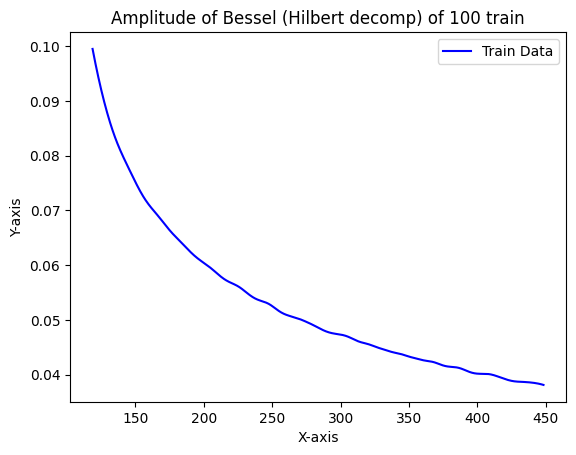

In [387]:
amplitude_bessel_0.plot_data()

In [388]:
amplitude_bessel_0.solve()

[0.005458681378513575, 5.0], 860.84, (0.091596610844 + (0.000044249879 * ((-3.061396837234) * X1))), 0.00
[0.004458957351744175, 6.0], 865.38, (0.128649145365 + ((-0.004161629826) * sqrt((1.195526719093 * X1)))), 0.00
[0.001220273319631815, 7.0], 865.06, (0.017903098837 + (25.234313964844 * (1.159319758415 / (3.342853546143 * X1)))), 0.00
[0.0005701690097339451, 9.0], 879.83, ((-0.120868846774) + (0.001854866510 * (((-2.330634117126) * X1) / (1.158840775490 - (0.029657149687 * X1))))), 0.00
[0.00031109582050703466, 10.0], 873.38, (0.009003249928 + (0.050431843847 * sqrt(((-3.725838422775) / (2.323075056076 - (0.029657149687 * X1)))))), 0.00
[0.00013671006308868527, 11.0], 875.33, ((-0.024508658797) + (0.079858586192 * sqrt(sqrt(((-4.095312595367) / (2.961619138718 - (0.030909793451 * X1))))))), 0.00
[0.0001305065379710868, 13.0], 884.30, (0.003011092544 + (0.247267276049 * ((2.519518136978 - sqrt(sqrt((0.609925508499 * X1)))) / (2.557542562485 - (0.030128229409 * X1))))), 0.00
[0.00012

<Axes: title={'center': 'Amplitude of Bessel (Hilbert decomp) of 100 - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

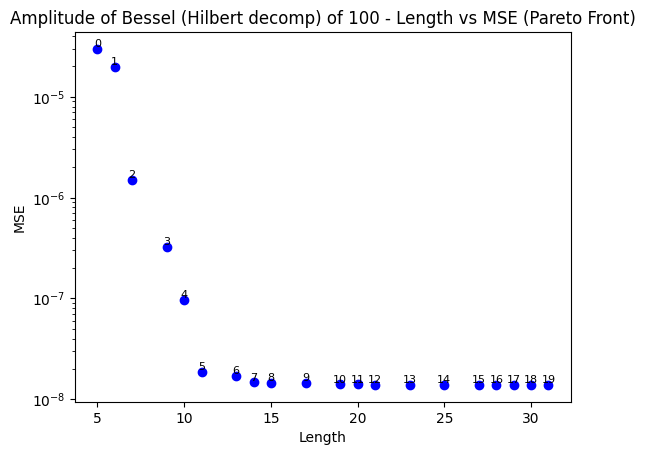

In [390]:
amplitude_bessel_0.plot_l_vs_mse()

b0*sqrt(-1/(-X1*b1 - X1*b2/(-X1*b4 + b3))) + b5


<IPython.core.display.Math object>

{'b0': 0.9835046424689153,
 'b1': 1.7724539041519165,
 'b2': 1.438378453254927,
 'b3': 1.9598082304000854,
 'b4': 0.02965714968700084,
 'b5': 0.001788321300000062}

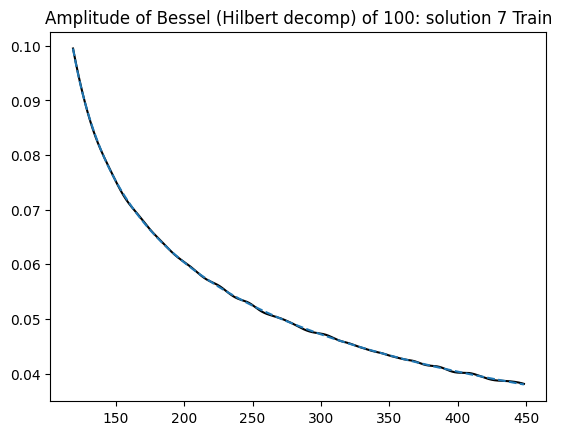

In [393]:
c_amp = 7
print(amplitude_bessel_0.solutions[c_amp].sympy_expr)
amplitude_bessel_0.solutions[c_amp].plot_results()
amplitude_bessel_0.solutions[c_amp].display_expression()
amplitude_bessel_0.solutions[c_amp].b_vals

In [454]:
candidate_str_ampl = 'b0*sqrt(-1/(-X1*b1 - X1*b2/(-X1*b4 + b3)))'
Candidate_ampl = Promising_solution(sp.parsing.sympy_parser.parse_expr(candidate_str_ampl), (x_data_spline_final, spline_amplitude_final), amplitude_bessel_0.solutions[c_amp], amplitude_bessel_0.solutions[c_amp].b_vals)

In [455]:
manual_expression_string = "b0/sqrt(b1)"
manual_target_value =  np.sqrt(2/np.pi)
full_param_symbols = [sp.Symbol(f'b{i}') for i in range(5)]

parameter_limit_inf_constraint = create_arbitrary_constraint(manual_expression_string, manual_target_value, full_param_symbols ,constraint_type='eq')
constraints_man = []
constraints_man.append(parameter_limit_inf_constraint)

Candidate_ampl.optimisation(constraints_eq=constraints_man)
#Candidate_ampl.optimisation()

`xtol` termination condition is satisfied.
Number of iterations: 106, function evaluations: 690, CG iterations: 262, optimality: 2.19e-05, constraint violation: 2.22e-16, execution time: 0.13 s.

Optimization summary:
Parameter | Old Value | New Value | Abs Difference
--------- | --------- | --------- | --------------
b0        | 0.983505  | 1.17332   | 0.189819      
b1        | 1.77245   | 2.1625    | 0.390041      
b2        | 1.43838   | 0.683583  | 0.754795      
b3        | 1.95981   | 2.39416   | 0.434351      
b4        | 0.0296571 | 0.0254527 | 0.00420441    



(1.17332315640432*sqrt(-1/(-2.16249524301565*X1 - 0.683582968778294*X1/(2.39415891842354 - 0.0254527391312872*X1))),
 {'b0': np.float64(1.1733231564043198),
  'b1': np.float64(2.1624952430156466),
  'b2': np.float64(0.6835829687782944),
  'b3': np.float64(2.394158918423545),
  'b4': np.float64(0.02545273913128724)},
 {'b0': np.float64(0.1898185139354045),
  'b1': np.float64(0.39004133886373005),
  'b2': np.float64(0.7547954844766327),
  'b3': np.float64(0.43435068802345933),
  'b4': np.float64(0.004204410555713599)},
 np.float64(0.02033428000938322))

{'b0': np.float64(1.1733231564043198),
 'b1': np.float64(2.1624952430156466),
 'b2': np.float64(0.6835829687782944),
 'b3': np.float64(2.394158918423545),
 'b4': np.float64(0.02545273913128724)}

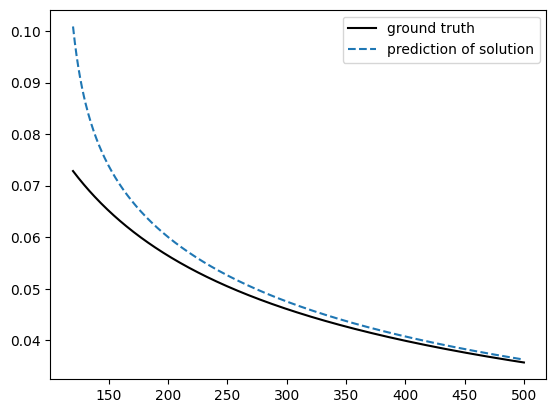

In [530]:
x_data = np.linspace(120, 500, 500)

Candidate_ampl.plot_comparison(x_data, np.sqrt(2/(np.pi*x_data)))
Candidate_ampl.modified_parameters
#Candidate_ampl.plot_comparison()

In [273]:
phase_bessel_0_args = {
    'allowed_symbols': "add,sub,mul,div,constant,variable",
    'epsilon': 1e-5,
    'objectives': ['rmse', 'length'], 
    'max_evaluations': int(1e16),
    'generations': int(1e16),
    'max_length': 50,
    'max_time': 60*3,
    'n_threads': 12,
}

phase_bessel_0 = Problem(f"Phase of Bessel (Hilbert decomp) of {order}", (x_data_spline_final, target_phase_spline_final), (x_data_spline_final, target_phase_spline_final), phase_bessel_0_args)

In [274]:
phase_bessel_0.solve()

[3.0428242683410645, 5.0], 5183.11, ((-113.324592590332) + (2.595183134079 * (0.352846264839 * X1))), 9.26
[3.0072989463806152, 7.0], 5119.69, ((-113.208610534668) + (11079.780273437500 * ((1.669709444046 * X1) - (1.669626832008 * X1)))), 9.04
[0.12446923553943634, 9.0], 918.22, ((-162.285858154297) + (12.220692634583 * ((6.440030097961 / (0.013681041077 * X1)) + (0.082366965711 * X1)))), 0.02
[0.05160744488239288, 11.0], 921.83, ((-155.127563476562) + (3418.571289062500 * (((-0.350746273994) / (6.135168075562 - (0.286745667458 * X1))) - ((-0.000291632750) * X1)))), 0.00
[0.051554810255765915, 13.0], 931.30, ((-155.227691650391) + (3419.059326171875 * (((-1.107037425041) / ((6.061503410339 - (0.287147730589 * X1)) * 3.137430906296)) - ((-0.000291632750) * X1)))), 0.00
[0.05153099447488785, 15.0], 965.56, (46754.660156250000 + ((-3418.620605468750) * (7.506232261658 - (((-0.350746273994) / (6.140202522278 - (0.286745667458 * X1))) - (((-0.000291632750) * X1) + 6.215615749359))))), 0.00


<Axes: title={'center': 'Phase of Bessel (Hilbert decomp) of 100 - Length vs MSE (Pareto Front)'}, xlabel='Length', ylabel='MSE'>

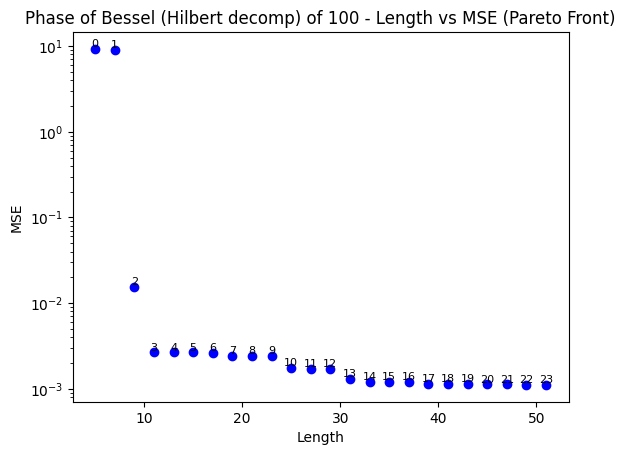

In [276]:
phase_bessel_0.plot_l_vs_mse()

X1*b0 - b1 - b2/(X1*b3 + X1*b4/(X1*b5 - b6) + X1*b7/(-X1*b9 + b8) - b10/(-X1*b9 + b11)) + b12/X1


<IPython.core.display.Math object>

{'b0': 0.9962954373449975,
 'b1': 155.41766357421875,
 'b2': 1494.8573384033516,
 'b3': 0.5880047082899864,
 'b4': 0.3640107214450268,
 'b5': 0.028915166855000507,
 'b6': 1.9387202262880692,
 'b7': 0.028893698006999813,
 'b8': 6.608863830566406,
 'b9': 0.013681041076999634,
 'b10': 0.35074627399399105,
 'b11': 6.139403343200684,
 'b12': 6937.782891511917}

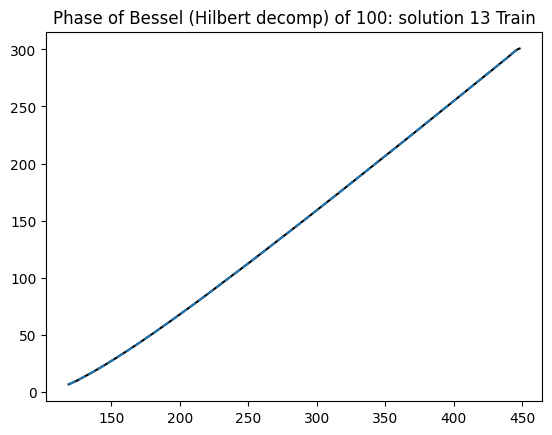

In [307]:
c_phi = 13
print(str(phase_bessel_0.solutions[c_phi].sympy_expr))
phase_bessel_0.solutions[c_phi].plot_results()
phase_bessel_0.solutions[c_phi].display_expression()
phase_bessel_0.solutions[c_phi].b_vals


In [457]:
candidate_str = f'X1 - ({order}*pi/2+pi/4) - b2/(X1*b3 + X1*b4/(X1*b5 - b6) + X1*b7/(-X1*b9 + b8) - b10/(-X1*b9 + b11)) + b12/X1'

Candidate_phase = Promising_solution(sp.parsing.sympy_parser.parse_expr(candidate_str), (x_data_spline_final, target_phase_spline_final), phase_bessel_0.solutions[c_phi], phase_bessel_0.solutions[c_phi].b_vals)

In [458]:
# manual_expression_string = "b2/b3 - b5"
# manual_target_value =  -(order*np.pi/2+np.pi/4)
# full_param_symbols = [sp.Symbol(f'b{i}') for i in range(1,8)]

# parameter_limit_inf_constraint = create_arbitrary_constraint(manual_expression_string, manual_target_value, full_param_symbols ,constraint_type='eq')
# constraints_man = []
# constraints_man.append(parameter_limit_inf_constraint)

Candidate_phase.optimisation()

`xtol` termination condition is satisfied.
Number of iterations: 3394, function evaluations: 40728, CG iterations: 36511, optimality: 1.17e+00, constraint violation: 0.00e+00, execution time:  7.2 s.

Optimization summary:
Parameter | Old Value | New Value | Abs Difference
--------- | --------- | --------- | --------------
b10       | 0.350746  | 0.52467   | 0.173924      
b11       | 6.1394    | 6.37593   | 0.236524      
b12       | 6937.78   | 6937.85   | 0.069423      
b2        | 1494.86   | 1494.82   | 0.0339062     
b3        | 0.588005  | 0.767303  | 0.179298      
b4        | 0.364011  | 0.975412  | 0.611401      
b5        | 0.0289152 | 0.0258641 | 0.00305106    
b6        | 1.93872   | 1.64446   | 0.29426       
b7        | 0.0288937 | 3.70085   | 3.67196       
b8        | 6.60886   | 5.22636   | 1.3825        
b9        | 0.013681  | 0.108297  | 0.0946158     



(X1 - 201*pi/4 - 1494.8234322216/(0.767302922630673*X1 + 0.975411671605931*X1/(0.0258641079926972*X1 - 1.64445989221715) + 3.70085130537577*X1/(5.22635946089293 - 0.108296864315334*X1) - 0.524670045978321/(6.37592771426275 - 0.108296864315334*X1)) + 6937.85231451215/X1,
 {'b10': np.float64(0.5246700459783213),
  'b11': np.float64(6.375927714262753),
  'b12': np.float64(6937.852314512154),
  'b2': np.float64(1494.823432221601),
  'b3': np.float64(0.7673029226306733),
  'b4': np.float64(0.9754116716059306),
  'b5': np.float64(0.02586410799269718),
  'b6': np.float64(1.6444598922171454),
  'b7': np.float64(3.7008513053757737),
  'b8': np.float64(5.226359460892935),
  'b9': np.float64(0.10829686431533445)},
 {'b10': np.float64(0.1739237719843303),
  'b11': np.float64(0.23652437106206925),
  'b12': np.float64(0.06942300023729331),
  'b2': np.float64(0.0339061817505808),
  'b3': np.float64(0.17929821434068693),
  'b4': np.float64(0.6114009501609038),
  'b5': np.float64(0.0030510588623033283)

{'b10': np.float64(0.5246700459783213),
 'b11': np.float64(6.375927714262753),
 'b12': np.float64(6937.852314512154),
 'b2': np.float64(1494.823432221601),
 'b3': np.float64(0.7673029226306733),
 'b4': np.float64(0.9754116716059306),
 'b5': np.float64(0.02586410799269718),
 'b6': np.float64(1.6444598922171454),
 'b7': np.float64(3.7008513053757737),
 'b8': np.float64(5.226359460892935),
 'b9': np.float64(0.10829686431533445)}

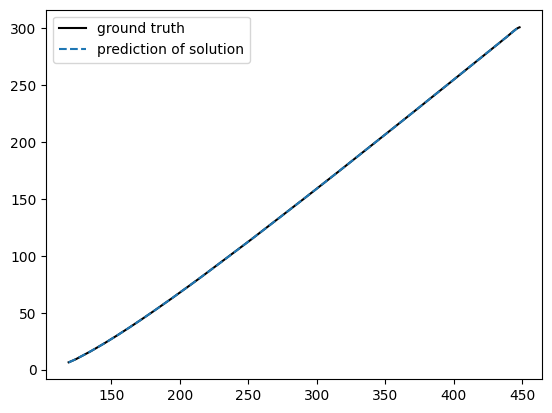

In [528]:
x_data = np.linspace(95, 100, 500)
#Candidate_phase.plot_comparison(x_data, y_data=x_data-order*np.pi/2-np.pi/4)
Candidate_phase.plot_comparison()
Candidate_phase.sympy_expr
Candidate_phase.modified_parameters

In [ ]:
import numpy as np
import sympy as sp
from tqdm import tqdm  # For a nice progress bar

def calculate_mse(y_true, y_pred):
    """Calculates the Mean Squared Error between true and predicted values."""
    squared_errors = (np.asarray(y_true) - np.asarray(y_pred))**2
    return np.mean(squared_errors)

def find_best_combination(amplitude_problem, phase_problem, x_data, y_true):
    """
    Iterates over all combinations of amplitude and phase solutions to find the one
    with the lowest Mean Squared Error (MSE).

    Args:
        amplitude_problem: The problem object containing a list of amplitude solutions.
        phase_problem: The problem object containing a list of phase solutions.
        x_data (np.ndarray): The x-values for evaluation.
        y_true (np.ndarray): The true y-values for comparison.

    Returns:
        dict: A dictionary containing the best found combination, including indices,
              MSE, the final symbolic expression, and the solution objects themselves.
    """
    best_mse = float('inf')
    best_amp_index = -1
    best_phase_index = -1
    best_expression = None
    
    X1 = sp.Symbol('X1')
    
    print("Searching for the best combination of Amplitude and Phase solutions...")
    
    # tqdm creates a smart progress bar for the outer loop
    for i, amp_sol in enumerate(tqdm(amplitude_problem.solutions, desc="Amplitude Solutions")):
        for j, phase_sol in enumerate(phase_problem.solutions):
            try:
                # Step 1: Substitute the numerical constants into the symbolic expressions
                A_numeric = amp_sol.sympy_expr.subs(amp_sol.b_vals)
                phi_numeric = phase_sol.sympy_expr.subs(phase_sol.b_vals)
                
                # Step 2: Combine them into the full physics-based expression
                reconstructed_expr = A_numeric * sp.cos(phi_numeric)
                
                # Step 3: Lambdify the expression to create a fast numerical function
                # This handles cases where the expression is just a constant (has no X1)
                if X1 in reconstructed_expr.free_symbols:
                    f_approx = sp.lambdify((X1,), reconstructed_expr, 'numpy')
                else:
                    const_val = float(reconstructed_expr)
                    f_approx = lambda x: np.full_like(x, const_val)

                # Step 4: Predict y-values over the specified interval
                y_pred = f_approx(x_data)
                
                # Skip if the prediction resulted in non-finite numbers (e.g., from 1/0)
                if not np.all(np.isfinite(y_pred)):
                    continue

                # Step 5: Calculate the MSE for this combination
                current_mse = calculate_mse(y_true, y_pred)
                
                # Step 6: If this is the best MSE so far, store the results
                if current_mse < best_mse:
                    best_mse = current_mse
                    best_amp_index = i
                    best_phase_index = j
                    best_expression = reconstructed_expr
                    
            except Exception:
                # If any error occurs during substitution or evaluation,
                # just skip to the next combination.
                continue
    
    if best_amp_index == -1:
        print("\nWarning: No valid combination was found.")
        return None
        
    print("\n--- Search Complete ---")
    print(f"Lowest MSE found: {best_mse:.6e}")
    print(f"Achieved with Amplitude solution index: {best_amp_index}")
    print(f"And Phase solution index: {best_phase_index}")
    
    return {
        'best_mse': best_mse,
        'best_amp_index': best_amp_index,
        'best_phase_index': best_phase_index,
        'best_amp_solution': amplitude_problem.solutions[best_amp_index],
        'best_phase_solution': phase_problem.solutions[best_phase_index],
        'best_expression': best_expression
    }

# Assume the following objects and data are already loaded:
# - amplitude_bessel_0: Your problem object with amplitude solutions
# - phase_bessel_0: Your problem object with phase solutions
# - x_data: The numpy array of x-values for evaluation
# - y_true: The numpy array of the true Bessel function values
x_data = np.linspace(95, 300, 500)
y_true = special.jv(order, x_data)
# Call the function to start the search
best_combination = find_best_combination(
    amplitude_problem=amplitude_bessel_0,
    phase_problem=phase_bessel_0,
    x_data=x_data,
    y_true=y_true
)

# You can now access the results from the returned dictionary
if best_combination:
    print("\n--- Best Found Symbolic Model ---")
    print(best_combination['best_expression'])
    
    # You can now take this best_combination and use it in your plotting script
    # For example:
    # bessel_approx_expr = best_combination['best_expression']
    # ... then lambdify and plot as you did before.

Overall Mean Squared Error (MSE): 3.724730e-07


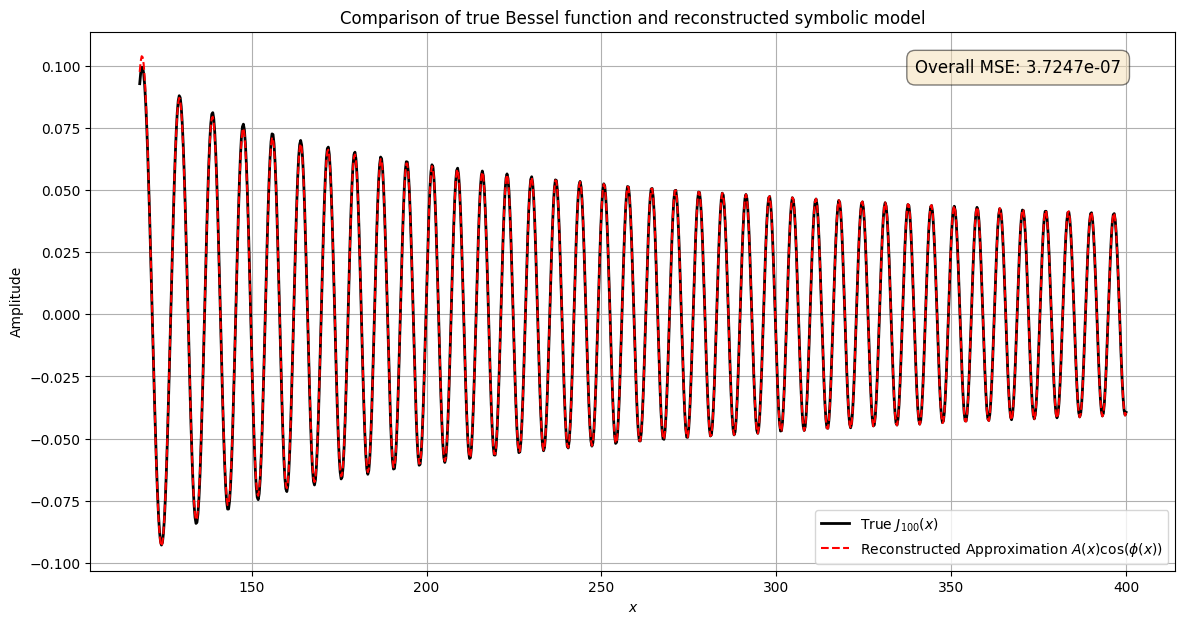

In [464]:

# 1. Define the symbolic variable
X1 = sp.Symbol('X1')

# 2. Extract the solution objects
# amp_solution = amplitude_bessel_0.solutions[4]
# phase_solution = phase_bessel_0.solutions[10]

amp_solution = Candidate_ampl
phase_solution = Candidate_phase


# 3. Get the symbolic expressions
A_expr = amp_solution.sympy_expr
phi_expr = phase_solution.sympy_expr

# --- STEP 1: SUBSTITUTE NUMERICAL CONSTANTS ---
# This is the critical new step.
# NOTE: You might need to change '.params' to the correct attribute name 
# that holds the dictionary of constant values (e.g., .constants_).
# A_numeric_expr = A_expr.subs(amp_solution.b_vals)
# phi_numeric_expr = phi_expr.subs(phase_solution.b_vals)

A_numeric_expr = A_expr.subs(amp_solution.modified_parameters)
phi_numeric_expr = phi_expr.subs(phase_solution.modified_parameters)

# 4. Combine the now-numeric expressions
bessel_approx_expr = A_numeric_expr * sp.cos(phi_numeric_expr)

# print("--- Final Expression with Numerical Constants ---")
# print(bessel_approx_expr)
# print("-" * 50)

# 5. Lambdify the final expression
# This now works because the only symbol left is X1.
# We keep the modules fix to be safe.
f_bessel_approx = sp.lambdify(
    (X1,), 
    bessel_approx_expr, 
    modules=[{'sqrt': np.sqrt}, 'numpy']
)

# 6. Generate data and plot (same as before)
x_data = np.linspace(118, 400, 1000)
y_true = special.jv(order, x_data)

# This call will now succeed.
y_pred = f_bessel_approx(x_data)


# Assuming y_true and y_pred have been calculated
overall_mse = calculate_mse(y_true, y_pred)

print(f"Overall Mean Squared Error (MSE): {overall_mse:.6e}")


# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(14, 7))

# Use the 'ax' object for all plotting commands
ax.plot(x_data, y_true, label=f'True $J_{{{order}}}(x)$', color='black', linewidth=2)
ax.plot(x_data, y_pred, label=r'Reconstructed Approximation $A(x) \cos(\phi(x)) $', color='red', linestyle='--')

# Set titles and labels on the axes object
ax.set_title('Comparison of true Bessel function and reconstructed symbolic model')
ax.set_xlabel('$x$')
ax.set_ylabel('Amplitude') # Added a Y-axis label for completeness
ax.legend()
ax.grid(True)

# The ax.text call will now work correctly
# (Assuming overall_mse is already calculated)
mse_text = f"Overall MSE: {overall_mse:.4e}"
ax.text(0.95, 0.95, mse_text, 
        transform=ax.transAxes, 
        fontsize=12,
        verticalalignment='top', 
        horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# Use plt.show() to display the figure
plt.show()


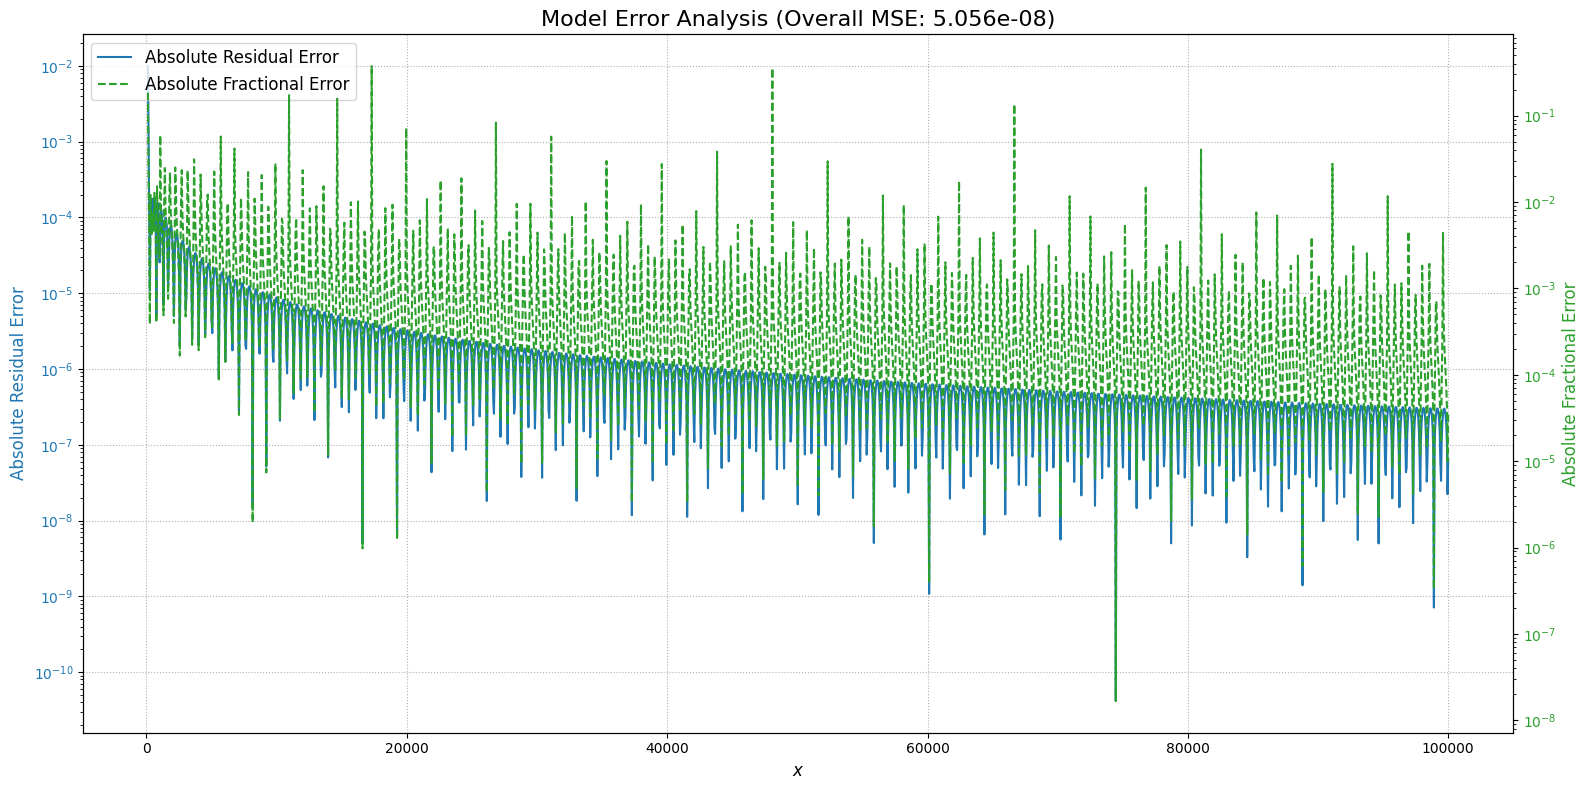

In [478]:
# Assume your calculate_mse function is defined elsewhere in your notebook
def calculate_mse(y_true, y_pred):
    return np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)

def plot_error_analysis(amp_candidate, phase_candidate, order_val, 
                        x_range=(110, 100000), num_points=2000,
                        plot_residual_abs=True, plot_fractional=True):
    """
    Generates a focused plot of the model's error, with options to show
    absolute residual error and/or fractional error.

    Args:
        amp_candidate: Your fitted candidate object for the amplitude.
        phase_candidate: Your fitted candidate object for the phase.
        order_val (int): The order of the Bessel function for the true data.
        x_range (tuple): The (start, end) of the x-axis for plotting.
        num_points (int): The number of points to generate for the plot.
        plot_residual_abs (bool): If True, plots the absolute residual error.
        plot_fractional (bool): If True, plots the absolute fractional error.
    """
    if not plot_residual_abs and not plot_fractional:
        print("No plots requested. Set 'plot_residual_abs' or 'plot_fractional' to True.")
        return

    X1 = sp.Symbol('X1')

    # 1. Prepare and lambdify the symbolic model
    A_expr = amp_candidate.sympy_expr.subs(amp_candidate.modified_parameters)
    phi_expr = phase_candidate.sympy_expr.subs(phase_candidate.modified_parameters)
    bessel_approx_expr = A_expr * sp.cos(phi_expr)
    f_bessel_approx = sp.lambdify((X1,), bessel_approx_expr, modules=['numpy'])

    # 2. Generate data
    x_data = np.linspace(x_range[0], x_range[1], num_points)
    y_true = special.jv(order_val, x_data)
    y_pred = f_bessel_approx(x_data)

    # 3. Calculate error metrics
    mse = calculate_mse(y_true, y_pred)
    residuals = y_true - y_pred
    absolute_residual_error = np.abs(residuals)
    
    epsilon = 1e-12 
    fractional_error = residuals / (np.abs(y_true) + epsilon)
    absolute_fractional_error = np.abs(fractional_error)

    # 4. Create the visualization based on flags
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax1.set_title(f"Model Error Analysis (Overall MSE: {mse:.3e})", fontsize=16)
    ax1.set_xlabel('$x$', fontsize=12)
    ax1.grid(True, linestyle=':')

    # Case 1: Plot both using a twin axis
    if plot_residual_abs and plot_fractional:
        ax2 = ax1.twinx()
        line1 = ax1.plot(x_data, absolute_residual_error, color='#1f77b4', label='Absolute Residual Error')
        ax1.set_ylabel('Absolute Residual Error', color='#1f77b4', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='#1f77b4')
        ax1.set_yscale("log")

        line2 = ax2.plot(x_data, absolute_fractional_error, color='#2ca02c', linestyle='--', label='Absolute Fractional Error')
        ax2.set_ylabel('Absolute Fractional Error', color='#2ca02c', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='#2ca02c')
        ax2.set_yscale("log")
        
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=12)

    # Case 2: Plot only the absolute residual error
    elif plot_residual_abs:
        ax1.plot(x_data, absolute_residual_error, color='#1f77b4', label='Absolute Residual Error')
        ax1.set_ylabel('Absolute Residual Error', fontsize=12)
        ax1.set_yscale("log")
        ax1.legend(loc='upper left', fontsize=12)

    # Case 3: Plot only the fractional error
    elif plot_fractional:
        ax1.plot(x_data, absolute_fractional_error, color='#2ca02c', linestyle='--', label='Absolute Fractional Error')
        ax1.set_ylabel('Absolute Fractional Error', fontsize=12)
        ax1.set_yscale("log")
        ax1.legend(loc='upper left', fontsize=12)

    plt.tight_layout()
    plt.show()

# --- HOW TO USE THE FUNCTION ---
# This cell should be run AFTER your cell where 'Candidate_ampl', 
# 'Candidate_phase', and 'order' are defined.

# Example 1: Plot both (default behavior)
# plot_error_analysis(Candidate_ampl, Candidate_phase, order)

# Example 2: Plot only the absolute residual error
# plot_error_analysis(Candidate_ampl, Candidate_phase, order, plot_fractional=False)

# Example 3: Plot only the absolute fractional error
plot_error_analysis(Candidate_ampl, Candidate_phase, order, plot_residual_abs=True)